In [1]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, LeakyReLU
from keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential,Model
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#생성자(generater setting)#
g = Sequential()
g.add(Dense(input_dim=100,units=7*7*128,activation=LeakyReLU(0.2)))
g.add(BatchNormalization()) 
g.add(Reshape((7,7,128)))
g.add(UpSampling2D())
g.add(Conv2D(filters=128,kernel_size=3,padding='Same'))
g.add(BatchNormalization())
g.add(Activation(LeakyReLU(0.2)))
g.add(UpSampling2D())
#판별자에게 넘기는 층 - 가짜데이터 정보
g.add(Conv2D(filters=1,kernel_size=3,padding='Same',activation='tanh')) 

#판별자#
d = Sequential()
d.add(Conv2D(filters=64,kernel_size=3,padding='Same', 
             input_shape=(28,28,1),strides=2))
d.add(Activation(LeakyReLU(0.2)))
d.add(Dropout(0.3))
d.add(Conv2D(filters=64,kernel_size=3,padding='Same', strides=2))
d.add(Activation(LeakyReLU(0.2)))
d.add(Dropout(0.3))
d.add(Flatten())
d.add(Dense(units=1,activation='sigmoid'))

d.compile(loss='binary_crossentropy',optimizer='adam') #'rmsprop'
d.trainable = False 

#gan 전체 생성#
gan_input = Input(shape=(100,))
h = g(gan_input)
gan_output = d(h)
gan = Model(gan_input, gan_output)
gan.compile(loss = 'binary_crossentropy', optimizer='adam')

#학습 함수#
def gan_train(epoch, batch_size, save_interval):
    (X_train,_),(_,_) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')
    X_train = (X_train-127.5)/127.5
    true_label = np.ones((batch_size,1)) #진짜데이터라벨
    fake_label = np.zeros((batch_size,1)) #가짜데이터라벨
    #학습#
    for e in range(epoch):
        #판별자 학습#
        true_data=X_train[np.random.randint(0, X_train.shape[0], batch_size)]#진짜데이터
        d_loss_true = d.train_on_batch(true_data, true_label) #학습
        
        noise = np.random.normal(0,1,size=(batch_size,100))
        fake_data = g.predict(noise)#가짜데이터
        d_loss_fake = d.train_on_batch(fake_data, fake_label) #학습
        
        d_loss = 0.5 * np.add(d_loss_true, d_loss_fake)#판별자 loss
        #생성자 학습#
        g_loss = gan.train_on_batch(noise, true_label)
        
        print('Epoch :', e+1, '\tD_LOSS:',round(d_loss,4),
              '\tG_LOSS:',round(g_loss,4))
        
        ##그림
        if e % save_interval==0:
            noise = np.random.normal(0,1,size=(25,100))
            imgs = g.predict(noise)
            imgs = 0.5 * imgs + 0.5  #정규화
            
            fig, axs = plt.subplots(5,5)
            num_of_imgs = 0 #그림의 순번 관리
            for i in range(5):
                for j in range(5):
                    axs[i,j].imshow(imgs[num_of_imgs, :, :, 0],cmap='gray')
                    axs[i,j].axis('off')
                    num_of_imgs += 1

In [ ]:
##생성자##
#가로7 세로7 이미지
#BatchNormalization:분포된 데이터 값들 nomalize
#Reshape 의 인자 :차원의 형태 -이미지 형태 표현
#숫자 채워줌 upsampling-->이미지 사이즈 14*14가 됨 -사이즈 불리기
#합성곱(filters=노드의 개수, kernel_size=filter사이즈(3행3열),padding=제로패딩)
#활성화함수 설정 - parameter로 관리되던 정보값들을 개별적인 층처럼 취급할 수 있는 layer로 쌓을 수 있음
##판별자##
#합성곱에서 풀링하지 않고 stride를 (2,2)로 하는 것으로 대체 - 성능괜찮다는 논문
#Dense:진짜인지 가짜인지 분류 -binary
#trainable 끔 - d가 gan안에서는 훈련X
##GAN 생성 - 전체 model##
# h: 중간결과물
#compile 을 해야만 학습이 가능한 상태 - 정보주입(신경망을 쌓으면 무조건 compile작업 수행)
#binary: 판별자와 같음
##학습함수##
#gan_train(에폭수, 배치크기, 인터벌)
#X_train셋 만 이용 (_:Don't care=>실질적으로 저장 안함)
#데이터 전처리 - 이미지 형태, 32비트 실수형으로 데이터타입 바꿔줌
#데이터 정규화를 -1 ->+1 (이렇게 만들어진 데이터 ;가공된 이미지 데이터의 픽셀값)

#그림
#인터버의 배수일 때 가상데이터를 보겠다.
#imgs :25장의 가상 이미지
#스케일링
#plt.subplots - plt.subplot과는 다른 함수

Epoch : 1 	D_LOSS: 0.6882 	G_LOSS: 0.7015
Epoch : 2 	D_LOSS: 0.5506 	G_LOSS: 0.6467
Epoch : 3 	D_LOSS: 0.4969 	G_LOSS: 0.5024
Epoch : 4 	D_LOSS: 0.4844 	G_LOSS: 0.3608
Epoch : 5 	D_LOSS: 0.4928 	G_LOSS: 0.2618
Epoch : 6 	D_LOSS: 0.4905 	G_LOSS: 0.1946
Epoch : 7 	D_LOSS: 0.4748 	G_LOSS: 0.173
Epoch : 8 	D_LOSS: 0.4615 	G_LOSS: 0.1612
Epoch : 9 	D_LOSS: 0.4442 	G_LOSS: 0.137
Epoch : 10 	D_LOSS: 0.4575 	G_LOSS: 0.1151
Epoch : 11 	D_LOSS: 0.4746 	G_LOSS: 0.108
Epoch : 12 	D_LOSS: 0.5045 	G_LOSS: 0.1083
Epoch : 13 	D_LOSS: 0.5474 	G_LOSS: 0.1269
Epoch : 14 	D_LOSS: 0.5657 	G_LOSS: 0.1536
Epoch : 15 	D_LOSS: 0.5811 	G_LOSS: 0.1836
Epoch : 16 	D_LOSS: 0.5744 	G_LOSS: 0.2297
Epoch : 17 	D_LOSS: 0.5466 	G_LOSS: 0.2733
Epoch : 18 	D_LOSS: 0.5146 	G_LOSS: 0.3373
Epoch : 19 	D_LOSS: 0.4882 	G_LOSS: 0.4059
Epoch : 20 	D_LOSS: 0.4459 	G_LOSS: 0.4651
Epoch : 21 	D_LOSS: 0.4005 	G_LOSS: 0.5716
Epoch : 22 	D_LOSS: 0.3583 	G_LOSS: 0.6503
Epoch : 23 	D_LOSS: 0.3124 	G_LOSS: 0.7465
Epoch : 24 	D_LOSS: 0.2

Epoch : 191 	D_LOSS: 0.2862 	G_LOSS: 0.7587
Epoch : 192 	D_LOSS: 0.265 	G_LOSS: 0.6764
Epoch : 193 	D_LOSS: 0.2724 	G_LOSS: 0.6829
Epoch : 194 	D_LOSS: 0.3165 	G_LOSS: 0.6389
Epoch : 195 	D_LOSS: 0.3231 	G_LOSS: 0.6465
Epoch : 196 	D_LOSS: 0.3556 	G_LOSS: 0.634
Epoch : 197 	D_LOSS: 0.3229 	G_LOSS: 0.6579
Epoch : 198 	D_LOSS: 0.36 	G_LOSS: 0.6816
Epoch : 199 	D_LOSS: 0.3746 	G_LOSS: 0.6885
Epoch : 200 	D_LOSS: 0.3795 	G_LOSS: 0.8134
Epoch : 201 	D_LOSS: 0.4449 	G_LOSS: 0.7778
Epoch : 202 	D_LOSS: 0.4575 	G_LOSS: 0.8763
Epoch : 203 	D_LOSS: 0.4663 	G_LOSS: 0.9092
Epoch : 204 	D_LOSS: 0.522 	G_LOSS: 0.9114
Epoch : 205 	D_LOSS: 0.5888 	G_LOSS: 0.9142
Epoch : 206 	D_LOSS: 0.5625 	G_LOSS: 0.9891
Epoch : 207 	D_LOSS: 0.5885 	G_LOSS: 1.0062
Epoch : 208 	D_LOSS: 0.6338 	G_LOSS: 1.0085
Epoch : 209 	D_LOSS: 0.6162 	G_LOSS: 0.9751
Epoch : 210 	D_LOSS: 0.6481 	G_LOSS: 1.0298
Epoch : 211 	D_LOSS: 0.6078 	G_LOSS: 1.0398
Epoch : 212 	D_LOSS: 0.7292 	G_LOSS: 1.0008
Epoch : 213 	D_LOSS: 0.7178 	G_LOSS: 

Epoch : 378 	D_LOSS: 0.5278 	G_LOSS: 0.9568
Epoch : 379 	D_LOSS: 0.5134 	G_LOSS: 1.0115
Epoch : 380 	D_LOSS: 0.4874 	G_LOSS: 1.0244
Epoch : 381 	D_LOSS: 0.4661 	G_LOSS: 1.115
Epoch : 382 	D_LOSS: 0.4392 	G_LOSS: 1.1645
Epoch : 383 	D_LOSS: 0.4262 	G_LOSS: 1.2336
Epoch : 384 	D_LOSS: 0.4199 	G_LOSS: 1.255
Epoch : 385 	D_LOSS: 0.4686 	G_LOSS: 1.1588
Epoch : 386 	D_LOSS: 0.4873 	G_LOSS: 1.1098
Epoch : 387 	D_LOSS: 0.4628 	G_LOSS: 1.1072
Epoch : 388 	D_LOSS: 0.4963 	G_LOSS: 1.0746
Epoch : 389 	D_LOSS: 0.5246 	G_LOSS: 1.0665
Epoch : 390 	D_LOSS: 0.5713 	G_LOSS: 0.9841
Epoch : 391 	D_LOSS: 0.6241 	G_LOSS: 0.9563
Epoch : 392 	D_LOSS: 0.6333 	G_LOSS: 0.9191
Epoch : 393 	D_LOSS: 0.6944 	G_LOSS: 0.9094
Epoch : 394 	D_LOSS: 0.7256 	G_LOSS: 0.7881
Epoch : 395 	D_LOSS: 0.7655 	G_LOSS: 0.7489
Epoch : 396 	D_LOSS: 0.7784 	G_LOSS: 0.8065
Epoch : 397 	D_LOSS: 0.8544 	G_LOSS: 0.7297
Epoch : 398 	D_LOSS: 0.8411 	G_LOSS: 0.723
Epoch : 399 	D_LOSS: 0.8984 	G_LOSS: 0.7015
Epoch : 400 	D_LOSS: 0.8872 	G_LOSS

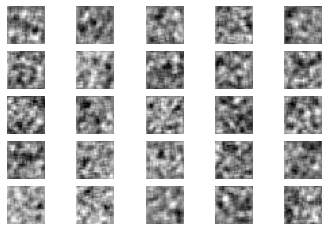

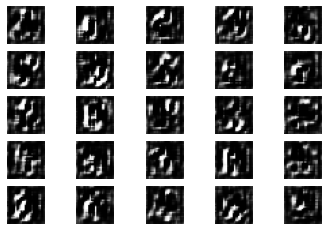

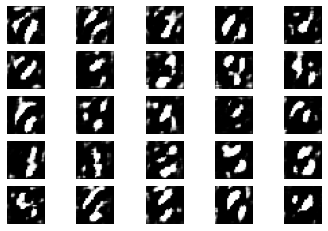

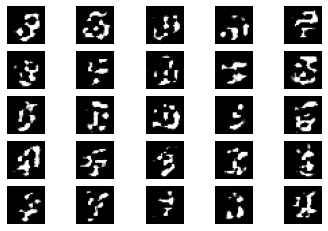

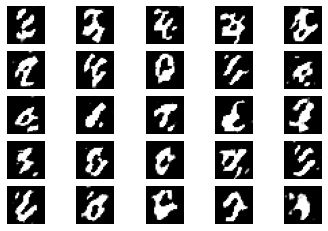

In [8]:
#gan_train(에폭수, 배치크기, 인터벌)
gan_train(500,128,100)
#100 : 100번째, 200번째,300번째,,,를 그래프 그리겠다